# **Caso 2: Múltiples centros de distribución con capacidad limitada**

## Modelo matemático

### Conjuntos

* $H$: conjunto de **centros de distribución** (depots).
* $C$: conjunto de **clientes**.
* $V$: conjunto de **vehículos**.
* $N = H \cup C$: conjunto de **todos los nodos**.

---

### Parámetros

* $q_c$: **demanda** del cliente $c \in C$.
* $r_v$: **capacidad** (kg) del vehículo $v \in V$.
* $\tau_v$: **autonomía máxima** (km) del vehículo $v \in V$.
* $w_{ij}$: **distancia** (km) entre nodos $i,j \in N$.
* $e_v$: **rendimiento de combustible** del vehículo $v$ (km/L).
* $p_f$: **precio del combustible** (COP/L).
* $c_o$: **costo fijo de activación** por vehículo (COP).
* $k_h$: **capacidad / inventario disponible** en el centro $h \in H$ (kg).

**Costos por arco:**
$$s_{ijv} = \frac{p_f}{e_v} \cdot w_{ij} \quad \forall i,j \in N, v \in V$$

---

### Variables de Decisión

* $x_{ijv} \in \{0,1\}$: **1** si el vehículo $v$ recorre el arco $i \to j$.
* $y_v \in \{0,1\}$: **1** si el vehículo $v$ es utilizado.
* $z_{cv} \in \{0,1\}$: **1** si el cliente $c$ es atendido por el vehículo $v$.
* $z_{hv} \in \{0,1\}$: **1** si el vehículo $v$ está asignado al centro $h$.
* $u_{cv} \ge 0$: **carga acumulada** en el vehículo $v$ justo después de atender al cliente $c$ (para MTZ).
* $L_{hv} \ge 0$: **carga total** que el vehículo $v$ entrega saliendo del centro $h$ (para la capacidad de los centros).

---

### Función Objetivo

Minimizar el costo total de operación:

$$\min Z = \sum_{v \in V}\sum_{i \in N}\sum_{j \in N} s_{ijv} x_{ijv} + \sum_{v \in V} c_o y_v$$

---

### Restricciones

#### 1. Prohibir bucles en el mismo nodo
$$x_{iiv} = 0 \quad \forall i \in N, v \in V$$

#### 2. Si el vehículo no está activo, no puede usar arcos
$$x_{ijv} \le y_v \quad \forall i,j \in N, v \in V$$

#### 3. Flujo de entrada a clientes
*La suma de arcos que llegan a un cliente ($c$) por ($v$) coincide con ($z_{cv}$)*:
$$\sum_{i \in N, i \ne c} x_{icv} = z_{cv} \quad \forall c \in C, v \in V$$

#### 4. Flujo de salida de clientes
$$\sum_{j \in N, j \ne c} x_{cjv} = z_{cv} \quad \forall c \in C, v \in V$$

#### 5. Cada cliente se atiende exactamente una vez
$$\sum_{v \in V} z_{cv} = 1 \quad \forall c \in C$$

#### 6. Capacidad por vehículo
$$\sum_{c \in C} q_c z_{cv} \le r_v y_v \quad \forall v \in V$$

#### 7. Asignación única de vehículo a centro
$$\sum_{h \in H} z_{hv} = y_v \quad \forall v \in V$$

#### 8. Salida desde el centro asignado
*Cada vehículo sale exactamente una vez del centro al que está asignado:*
$$\sum_{j \in C} x_{hjv} = z_{hv} \quad \forall h \in H, v \in V$$

#### 9. Retorno al mismo centro
$$\sum_{i \in C} x_{ihv} = z_{hv} \quad \forall h \in H, v \in V$$

#### 10. Autonomía (límite de distancia)
$$\sum_{i \in N}\sum_{j \in N, j\ne i} w_{ij} x_{ijv} \le \tau_v y_v \quad \forall v \in V$$

#### 11. Límites de $u_{cv}$ (para MTZ)
$$u_{cv} \ge q_c z_{cv} \quad \forall c \in C, v \in V$$
$$u_{cv} \le r_v z_{cv} \quad \forall c \in C, v \in V$$

#### 12. MTZ – Eliminación de subtours por vehículo
$$u_{cv} - u_{jv} + r_v x_{cjv} \le r_v - q_j z_{jv} \quad \forall c,j \in C, c \ne j, v \in V$$

#### 13. Definición de carga por centro–vehículo
$$\sum_{h \in H} L_{hv} = \sum_{c \in C} q_c z_{cv} \quad \forall v \in V$$

#### 14. Vínculo carga–asignación de vehículo a centro
$$L_{hv} \le r_v z_{hv} \quad \forall h \in H, v \in V$$

#### 15. Capacidad de inventario por centro
$$\sum_{v \in V} L_{hv} \le k_h \quad \forall h \in H$$

## Implementación en pyomo

In [11]:
import math
import time
from pathlib import Path

import pandas as pd
import pyomo.environ as pyo

start_time = time.time()

# =========================================================
# 1. Lectura de datos
# =========================================================

clients_df = pd.read_csv("clients.csv")
depots_df  = pd.read_csv("depots.csv") 
veh_df     = pd.read_csv("vehicles.csv")
params_df  = pd.read_csv("parameters_urban.csv")

# --- Depósitos (H) ---
# Se asume: DepotID, Latitude, Longitude, Capacity
depots_external = depots_df["DepotID"].astype(str).tolist()
H = list(range(len(depots_external)))  # índices internos 0..|H|-1

idx_to_external = {}
external_to_idx = {}

for h_idx, (_, row) in enumerate(depots_df.iterrows()):
    dep_id = str(row["DepotID"])
    idx_to_external[h_idx] = dep_id
    external_to_idx[dep_id] = h_idx

coords = {}   # lat, lon por índice interno
k_h    = {}   # capacidad / inventario del centro

for h_idx, (_, row) in enumerate(depots_df.iterrows()):
    coords[h_idx] = (float(row["Latitude"]), float(row["Longitude"]))
    k_h[h_idx]    = float(row.get("Capacity", 0.0))

# --- Clientes (C) ---
# Se asume: ClientID, Latitude, Longitude, Demand
clients_external = clients_df["ClientID"].astype(str).tolist()

C = list(range(len(H), len(H) + len(clients_external)))  # índices internos para clientes

for i_int, cid in zip(C, clients_external):
    cid_s = str(cid)
    idx_to_external[i_int]  = cid_s
    external_to_idx[cid_s]  = i_int

for _, r in clients_df.iterrows():
    cid  = str(r["ClientID"])
    idx  = external_to_idx[cid]
    coords[idx] = (float(r["Latitude"]), float(r["Longitude"]))

demand = {}
for _, r in clients_df.iterrows():
    cid  = str(r["ClientID"])
    idx  = external_to_idx[cid]
    demand[idx] = float(r["Demand"])

# --- Vehículos (V) ---
# Se asume: VehicleID, Capacity, Range, FuelEfficiency (opcional)
V_list = veh_df["VehicleID"].astype(str).tolist()

rv = {}   # capacidad
tv = {}   # autonomía (km)
ev = {}   # eficiencia (km/L)

for _, r in veh_df.iterrows():
    vid = str(r["VehicleID"])
    rv[vid] = float(r.get("Capacity", 0.0))
    tv[vid] = float(r.get("Range", 0.0))
    ev[vid] = float(
        r.get(
            "FuelEfficiency",
            params_df.loc[params_df["Parameter"] == "fuel_efficiency_typical", "Value"].iloc[0]
            if ("fuel_efficiency_typical" in params_df["Parameter"].values)
            else 10.0,
        )
    )

# Parámetros globales
def pval(name, default):
    s = params_df.loc[params_df["Parameter"] == name, "Value"]
    return float(s.iloc[0]) if not s.empty else default

pf = pval("fuel_price", 12000.0)                       # COP/L
fuel_eff_typ = pval("fuel_efficiency_typical", 10.0)   # km/L
co = pval("fixed_vehicle_cost", 50000.0)               # costo fijo por vehículo

# Completar eficiencias faltantes
for vid in V_list:
    if vid not in ev or ev[vid] <= 0:
        ev[vid] = fuel_eff_typ

# =========================================================
# 2. Conjuntos, distancias y parámetros
# =========================================================

NODOS = H + C
N = NODOS

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = (math.sin(dphi / 2.0) ** 2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# matriz de distancias
w = {}
for i in N:
    for j in N:
        if i == j:
            w[i, j] = 0.0
        else:
            lat1, lon1 = coords[i]
            lat2, lon2 = coords[j]
            w[i, j] = haversine_km(lat1, lon1, lat2, lon2)

# =========================================================
# 3. Modelo Pyomo
# =========================================================

model = pyo.ConcreteModel()

model.H = pyo.Set(initialize=H)          # centros
model.C = pyo.Set(initialize=C)          # clientes
model.N = pyo.Set(initialize=N)          # nodos
model.V = pyo.Set(initialize=V_list)     # vehículos

# Parámetros
model.w   = pyo.Param(model.N, model.N, initialize=w,   within=pyo.NonNegativeReals)
model.q   = pyo.Param(model.C,            initialize=demand, within=pyo.NonNegativeReals)
model.r   = pyo.Param(model.V,            initialize=rv,    within=pyo.NonNegativeReals)
model.tau = pyo.Param(model.V,            initialize=tv,    within=pyo.NonNegativeReals)
model.e   = pyo.Param(model.V,            initialize=ev,    within=pyo.PositiveReals)
model.k   = pyo.Param(model.H,            initialize=k_h,   within=pyo.NonNegativeReals)

model.co  = pyo.Param(initialize=co)
model.pf  = pyo.Param(initialize=pf)

# costo por arco (combustible)
def s_init(m, i, j, v):
    if i == j:
        return 0.0
    return (m.pf / m.e[v]) * m.w[i, j]

model.s = pyo.Param(model.N, model.N, model.V,
                    initialize=s_init, within=pyo.NonNegativeReals)

# =========================================================
# 4. Variables
# =========================================================

model.x   = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)   # arco (i,j) por v
model.y   = pyo.Var(model.V, domain=pyo.Binary)                     # vehículo usado
model.zc  = pyo.Var(model.C, model.V, domain=pyo.Binary)            # cliente c atendido por v
model.zh  = pyo.Var(model.H, model.V, domain=pyo.Binary)            # v asignado a centro h

max_cap = max(rv.values()) if rv else 1.0
model.u       = pyo.Var(model.C, model.V, bounds=(0, max_cap))      # carga acumulada en c
model.load_hv = pyo.Var(model.H, model.V, bounds=(0, max_cap))      # carga atribuida a (h,v)

# =========================================================
# 5. Restricciones
# =========================================================

# 5.1 Sin arcos i->i
def no_self_arcs(m, i, v):
    return m.x[i, i, v] == 0
model.no_self_arcs = pyo.Constraint(model.N, model.V, rule=no_self_arcs)

# 5.2 Prohibir arcos centro->centro
def no_depot_to_depot(m, i, j, v):
    if (i in m.H) and (j in m.H):
        return m.x[i, j, v] == 0
    return pyo.Constraint.Skip
model.no_depot_to_depot = pyo.Constraint(model.N, model.N, model.V,
                                         rule=no_depot_to_depot)

# 5.3 Vincular arcos y uso de vehículo
def link_x_y(m, i, j, v):
    return m.x[i, j, v] <= m.y[v]
model.link_x_y = pyo.Constraint(model.N, model.N, model.V, rule=link_x_y)

# 5.4 Flujo de entrada a clientes
def entry_def(m, c, v):
    return sum(m.x[i, c, v] for i in m.N if i != c) == m.zc[c, v]
model.entry_def = pyo.Constraint(model.C, model.V, rule=entry_def)

# 5.5 Flujo de salida de clientes
def exit_def(m, c, v):
    return sum(m.x[c, j, v] for j in m.N if j != c) == m.zc[c, v]
model.exit_def = pyo.Constraint(model.C, model.V, rule=exit_def)

# 5.6 Cada cliente atendido una sola vez
def cover_once(m, c):
    return sum(m.zc[c, v] for v in m.V) == 1
model.cover_once = pyo.Constraint(model.C, rule=cover_once)

# 5.7 Capacidad de vehículo
def capacity_rule(m, v):
    return sum(m.q[c] * m.zc[c, v] for c in m.C) <= m.r[v] * m.y[v]
model.capacity = pyo.Constraint(model.V, rule=capacity_rule)

# 5.8 Asignación única de vehículo a centro
def one_depot_per_vehicle(m, v):
    return sum(m.zh[h, v] for h in m.H) == m.y[v]
model.one_depot = pyo.Constraint(model.V, rule=one_depot_per_vehicle)

# 5.9 Salida desde el centro asignado
def depart_from_assigned(m, h, v):
    return sum(m.x[h, j, v] for j in m.C) == m.zh[h, v]
model.depart = pyo.Constraint(model.H, model.V, rule=depart_from_assigned)

# 5.10 Retorno al mismo centro
def return_to_assigned(m, h, v):
    return sum(m.x[i, h, v] for i in m.C) == m.zh[h, v]
model.return_depot = pyo.Constraint(model.H, model.V, rule=return_to_assigned)

# 5.11 Autonomía
def autonomy(m, v):
    return sum(m.x[i, j, v] * m.w[i, j]
               for i in m.N for j in m.N if i != j) <= m.tau[v] * m.y[v]
model.autonomy = pyo.Constraint(model.V, rule=autonomy)

# 5.12 MTZ: límites para u
def u_lower(m, c, v):
    return m.u[c, v] >= m.q[c] * m.zc[c, v]
model.u_low = pyo.Constraint(model.C, model.V, rule=u_lower)

def u_upper(m, c, v):
    return m.u[c, v] <= m.r[v] * m.zc[c, v]
model.u_up = pyo.Constraint(model.C, model.V, rule=u_upper)

# 5.13 MTZ: eliminación de subtours
def mtz_rule(m, c, j, v):
    if c == j:
        return pyo.Constraint.Skip
    return m.u[c, v] - m.u[j, v] + m.r[v] * m.x[c, j, v] \
           <= m.r[v] - m.q[j] * m.zc[j, v]
model.mtz = pyo.Constraint(model.C, model.C, model.V, rule=mtz_rule)

# 5.14 Definición de carga por centro-vehículo
def load_balance(m, v):
    return sum(m.load_hv[h, v] for h in m.H) \
           == sum(m.q[c] * m.zc[c, v] for c in m.C)
model.load_balance = pyo.Constraint(model.V, rule=load_balance)

def load_link(m, h, v):
    return m.load_hv[h, v] <= m.r[v] * m.zh[h, v]
model.load_link = pyo.Constraint(model.H, model.V, rule=load_link)

# 5.15 Capacidad de los centros
def depot_capacity(m, h):
    return sum(m.load_hv[h, v] for v in m.V) <= m.k[h]
model.depot_capacity = pyo.Constraint(model.H, rule=depot_capacity)

# =========================================================
# 6. Función objetivo
# =========================================================

def obj_rule(m):
    var_cost = sum(m.s[i, j, v] * m.x[i, j, v]
                   for i in m.N for j in m.N for v in m.V)
    fixed_cost = sum(m.co * m.y[v] for v in m.V)
    return var_cost + fixed_cost

model.OBJ = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

print("Modelo de Caso 2 construido correctamente.")

# =========================================================
# 7. Resolver el modelo
# =========================================================

solver = pyo.SolverFactory("glpk")  # o "gurobi" si tarda mucho con "glpk", etc.
results = solver.solve(model, tee=True)

print(results.solver.status)
print(results.solver.termination_condition)

# Si todo sale bien, mostrar el valor óptimo:
if (results.solver.status == pyo.SolverStatus.ok and
    results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("Valor óptimo Z =", pyo.value(model.OBJ))
else:
    print("El solver no encontró solución óptima.")



Modelo de Caso 2 construido correctamente.
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\LENOVO\AppData\Local\Temp\tmpxfnp8g14.glpk.raw --wglp C:\Users\LENOVO\AppData\Local\Temp\tmp652ziljy.glpk.glp
 --cpxlp C:\Users\LENOVO\AppData\Local\Temp\tmpzdlmapmu.pyomo.lp
Reading problem data from 'C:\Users\LENOVO\AppData\Local\Temp\tmpzdlmapmu.pyomo.lp'...
C:\Users\LENOVO\AppData\Local\Temp\tmpzdlmapmu.pyomo.lp:34069: warning: lower bound of variable 'x2529' redefined
C:\Users\LENOVO\AppData\Local\Temp\tmpzdlmapmu.pyomo.lp:34069: warning: upper bound of variable 'x2529' redefined
4545 rows, 2904 columns, 14994 non-zeros
2778 integer variables, all of which are binary
36847 lines were read
Writing problem data to 'C:\Users\LENOVO\AppData\Local\Temp\tmp652ziljy.glpk.glp'...
28389 lines were written
GLPK Integer Optimizer 5.0
4545 rows, 2904 columns, 14994 non-zeros
2778 integer variables, all of which are binary
Preprocessing...
52 constraint coeffi

## Generar archivo de verificación

In [12]:
import pandas as pd

# =========================================================
#   Funciones para formateo de identificadores
# =========================================================

def format_depot(ext_id):
    """
    ext_id = string del ID externo usado en idx_to_external 
             (puede venir como '1', 'CD01', 'H2', etc.)
    
    Siempre devolvemos CD## con dos dígitos.
    """
    # Extraemos número
    digits = "".join([c for c in ext_id if c.isdigit()])
    if digits == "":
        digits = "1"  # fallback
    return f"CD{int(digits):02d}"


def format_client(ext_id):
    """
    ext_id = string (ej: '15', 'C003', etc.)
    Devolvemos C### con 3 dígitos.
    """
    digits = "".join([c for c in ext_id if c.isdigit()])
    if digits == "":
        digits = "1"
    return f"C{int(digits):03d}"


def format_vehicle(v_id):
    """
    v_id = string (ej: '3', 'V01', etc.)
    Devolvemos V### con 3 dígitos.
    """
    digits = "".join([c for c in v_id if c.isdigit()])
    if digits == "":
        digits = "1"
    return f"V{int(digits):03d}"


# =========================================================
# 8. Reconstrucción de rutas y archivo verificacion_caso2.csv
# =========================================================

# 1) Velocidad promedio urbana para calcular el tiempo
urban_speed_kmh = 30.0
if "urban_speed_kmh" in params_df["Parameter"].values:
    urban_speed_kmh = float(
        params_df.loc[params_df["Parameter"] == "urban_speed_kmh", "Value"].iloc[0]
    )

rows = []

for v in model.V:
    # Solo vehículos usados
    if pyo.value(model.y[v]) < 0.5:
        continue

    # ----- Depot asignado a v -----
    depots_v = [h for h in model.H if pyo.value(model.zh[h, v]) > 0.5]
    if not depots_v:
        # Si por alguna razón no hay depot asignado, saltamos el vehículo
        continue
    h = depots_v[0]  # asumimos un único centro

    # IDs ya formateados estándar
    vehicle_ext = format_vehicle(v)
    depot_ext = format_depot(idx_to_external[h])

    # ----- Construir sucesor por arco seleccionado -----
    succ = {}
    for i in model.N:
        for j in model.N:
            if i == j:
                continue
            if pyo.value(model.x[i, j, v]) > 0.5:
                succ[i] = j

    # ----- Recorrer la ruta desde el depot -----
    route_nodes = [h]
    current = h
    visited = set()

    while True:
        if current not in succ:
            # No hay siguiente (por si algo quedó raro)
            break
        nxt = succ[current]
        route_nodes.append(nxt)

        if nxt in model.H:
            # Volvimos a un centro -> cerramos ruta
            break

        if nxt in visited:
            # Por seguridad, evitar ciclos infinitos
            break
        visited.add(nxt)
        current = nxt

    # ----- Métricas de ruta -----

    # route_ext formateado nodo por nodo
    route_ext = []
    for i in route_nodes:
        ext = idx_to_external[i]               # ID original
        if i in model.H:                       # es depot
            route_ext.append(format_depot(ext))
        else:                                  # es cliente
            route_ext.append(format_client(ext))

    # Clientes servidos en la ruta (nodos que están en C)
    clients_in_route = [i for i in route_nodes if i in model.C]

    # InitialLoad = demanda total atendida por ese vehículo
    initial_load = sum(
        pyo.value(model.q[c]) * pyo.value(model.zc[c, v]) for c in model.C
    )

    # ClientsServed
    clients_served = len(clients_in_route)

    # DemandsSatisfied (en el orden de visita)
    demands_satisfied = [
        float(pyo.value(model.q[c])) for c in clients_in_route
    ]

    # TotalDistance: sumar distancias de cada arco recorrido en la ruta
    total_dist = 0.0
    for i, j in zip(route_nodes[:-1], route_nodes[1:]):
        total_dist += float(pyo.value(model.w[i, j]))

    # TotalTime = distancia / velocidad (en horas) * 60 -> minutos
    total_time = (total_dist / urban_speed_kmh) * 60.0 if urban_speed_kmh > 0 else 0.0

    # FuelCost: suma de costos de combustible de los arcos usados por v
    fuel_cost = 0.0
    for i, j in zip(route_nodes[:-1], route_nodes[1:]):
        fuel_cost += float(pyo.value(model.s[i, j, v]))

    # ----- Construir la fila según el formato requerido -----
    row = {
        "VehicleId": vehicle_ext,
        "DepotId": depot_ext,
        "InitialLoad": initial_load,
        "RouteSequence": "-".join(route_ext),
        "ClientsServed": clients_served,
        "DemandsSatisfied": "-".join(
            f"{d:.0f}" if d.is_integer() else f"{d}" for d in demands_satisfied
        ),
        "TotalDistance": total_dist,
        "TotalTime": total_time,
        "FuelCost": fuel_cost,
    }
    rows.append(row)


# Crear DataFrame y guardar CSV
verif_df = pd.DataFrame(rows, columns=[
    "VehicleId",
    "DepotId",
    "InitialLoad",
    "RouteSequence",
    "ClientsServed",
    "DemandsSatisfied",
    "TotalDistance",
    "TotalTime",
    "FuelCost",
])

verif_df.to_csv("verificacion_caso2.csv", index=False)
print("Archivo 'verificacion_caso2.csv' generado correctamente.")


Archivo 'verificacion_caso2.csv' generado correctamente.


## Visualización de resultados – Caso 2 (Proyecto A)

En esta sección se construye un mapa interactivo con **Folium** que muestra:

- Las rutas completas recorridas por cada vehículo.
- Los centros de distribución como nodos de salida.
- Los clientes atendidos por cada ruta, junto con su demanda.

Esta visualización será usada en el informe para ilustrar la solución del Caso 2.


In [13]:
!pip install folium


In [16]:
# =========================================================
#  Visualización geográfica con Folium – Caso 2 Proyecto A
# =========================================================

# (Solo si NO tienes folium instalado, ejecuta esta línea 1 vez)
# !pip install folium

import folium
import pyomo.environ as pyo

# ------------------------------------------------------------------
# 0. Verificaciones básicas (evita errores de "name is not defined")
# ------------------------------------------------------------------
assert "model" in globals(),  "Primero ejecuta la celda donde se crea y resuelve el modelo."
assert "coords" in globals(), "Primero ejecuta la celda donde se construyen coords."
assert "idx_to_external" in globals(), "Ejecuta la celda donde se crean los índices."

# Si por alguna razón 'verif_df' no está en memoria (por no ejecutar la celda anterior),
# lo recargamos desde el CSV:
try:
    verif_df
except NameError:
    verif_df = pd.read_csv("verificacion_caso2.csv")

# ------------------------------
# 1. Centro del mapa
# ------------------------------
all_lats = [coords[i][0] for i in coords]
all_lons = [coords[i][1] for i in coords]

center_lat = sum(all_lats) / len(all_lats)
center_lon = sum(all_lons) / len(all_lons)

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles="CartoDB positron",
)

# ------------------------------
# 2. Dibujar centros de distribución
# ------------------------------
for h in model.H:
    lat, lon = coords[h]
    depot_ext_raw = idx_to_external[h]
    depot_std = format_depot(depot_ext_raw)

    folium.Marker(
        location=[lat, lon],
        popup=f"Centro de distribución {depot_std}",
        tooltip=f"CD {depot_std}",
        icon=folium.Icon(color="black", icon="home", prefix="fa"),
    ).add_to(m)

# ------------------------------
# 3. Colores para cada vehículo
# ------------------------------
color_list = [
    "red", "blue", "green", "purple", "orange",
    "darkred", "cadetblue", "darkgreen", "darkblue",
    "darkpurple", "lightred", "lightblue",
]

def color_for_vehicle(v_id: str) -> str:
    v_list = list(model.V)
    idx = v_list.index(v_id)
    return color_list[idx % len(color_list)]

# ------------------------------
# 4. Construir rutas por vehículo desde las x[i,j,v]
# ------------------------------
for v in model.V:

    # Solo vehículos usados
    if pyo.value(model.y[v]) < 0.5:
        continue

    veh_color = color_for_vehicle(v)

    # Depot asignado a v
    depots_v = [h for h in model.H if pyo.value(model.zh[h, v]) > 0.5]
    if not depots_v:
        continue   # por robustez
    h = depots_v[0]

    # Sucesor por arco
    succ = {}
    for i in model.N:
        for j in model.N:
            if i == j:
                continue
            if pyo.value(model.x[i, j, v]) > 0.5:
                succ[i] = j

    # Reconstruir ruta desde el CD asignado
    route_nodes = [h]
    current = h
    visited = set()

    while current in succ:
        nxt = succ[current]
        if nxt in visited:
            break
        route_nodes.append(nxt)
        visited.add(current)
        current = nxt
        if nxt in model.H and nxt != h:
            # si por alguna razón regresara a otro depot (no debería), paramos
            break

    # Coordenadas de la ruta
    route_coords = [(coords[i][0], coords[i][1]) for i in route_nodes]

    # Dibujar la polyline de la ruta
    veh_ext = format_vehicle(v)
    folium.PolyLine(
        locations=route_coords,
        weight=3,
        color=veh_color,
        opacity=0.8,
        tooltip=f"Ruta vehículo {veh_ext}",
    ).add_to(m)

    # Marcar clientes de la ruta (nivel de carga en el popup)
    for i in route_nodes:
        if i in model.C:
            cli_ext_raw = idx_to_external[i]
            cli_std = format_client(cli_ext_raw)
            demanda_i = float(pyo.value(model.q[i]))

            # Radio proporcional a la demanda (para que se vea la "carga")
            radius = 3 + demanda_i / 10.0

            folium.CircleMarker(
                location=coords[i],
                radius=radius,
                color=veh_color,
                fill=True,
                fill_opacity=0.9,
                popup=f"{cli_std} – Demanda: {demanda_i:.0f}",
            ).add_to(m)

# Mostrar el mapa en el notebook
m


## Análisis de resultados – Caso 2 (resumen numérico)

En esta sección se construyen tablas resumen por **vehículo** y por **centro de distribución**:
- Distancia total recorrida
- Tiempo de operación
- Demanda atendida
- Costo de combustible

Estas tablas alimentan el análisis cualitativo del informe (eficiencia de rutas, uso de CDs, etc.).


In [15]:
import numpy as np

# Asegurarnos de tener verif_df
try:
    verif_df
except NameError:
    verif_df = pd.read_csv("verificacion_caso2.csv")

# ----------------------------------
# 1. Parsear la columna DemandsSatisfied
# ----------------------------------
def parse_demands(d_str: str) -> float:
    if pd.isna(d_str) or d_str == "":
        return 0.0
    return sum(float(x) for x in str(d_str).split("-") if x != "")

analysis_df = verif_df.copy()
analysis_df["TotalDemand"] = analysis_df["DemandsSatisfied"].apply(parse_demands)

# Renombrar columnas para que el análisis quede más claro
analysis_df = analysis_df.rename(
    columns={
        "TotalDistance": "Distance_km",
        "TotalTime": "Time_min",
        "FuelCost": "FuelCost_COP",
    }
)

display(analysis_df)

# ----------------------------------
# 2. Totales globales
# ----------------------------------
print("\n=== Totales globales del Caso 2 ===")
print(f"Vehículos usados       : {len(analysis_df)}")
print(f"Demanda total atendida : {analysis_df['TotalDemand'].sum():.0f} unidades")
print(f"Distancia total        : {analysis_df['Distance_km'].sum():.2f} km")
print(f"Tiempo total           : {analysis_df['Time_min'].sum():.2f} minutos")
print(f"Costo total combustible: {analysis_df['FuelCost_COP'].sum():,.0f} COP")

# ----------------------------------
# 3. Resumen por centro de distribución
# ----------------------------------
per_depot = (
    analysis_df
    .groupby("DepotId")[["TotalDemand", "Distance_km", "Time_min", "FuelCost_COP"]]
    .sum()
    .reset_index()
)

print("\n=== Resumen por centro de distribución ===")
display(per_depot)

# ----------------------------------
# 4. Resumen por vehículo
# ----------------------------------
per_vehicle = (
    analysis_df
    .set_index("VehicleId")[["TotalDemand", "Distance_km", "Time_min", "FuelCost_COP"]]
    .sort_values("Distance_km", ascending=False)
)

print("\n=== Resumen por vehículo ===")
display(per_vehicle)

# (Opcional) algunos indicadores adicionales
analysis_df["AvgSpeed_kmh"] = analysis_df["Distance_km"] / (analysis_df["Time_min"] / 60.0)

print("\n=== Velocidad promedio por vehículo (km/h) ===")
display(analysis_df[["VehicleId", "AvgSpeed_kmh"]])


,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,Distance_km,Time_min,FuelCost_COP,TotalDemand
0,V001,CD09,42.0,CD09-C008-C007-C005-C003-CD09,4,10-12-5-15,21.761547,43.523093,35471.321105,42.0
1,V002,CD05,26.0,CD05-C006-C002-CD05,2,11-15,15.634559,31.269119,25484.331805,26.0
2,V003,CD12,18.0,CD12-C004-C001-CD12,2,6-12,20.997167,41.994334,34225.382196,18.0
3,V006,CD11,15.0,CD11-C009-CD11,1,15,6.877327,13.754654,11210.043070,15.0



=== Totales globales del Caso 2 ===
Vehículos usados       : 4
Demanda total atendida : 101 unidades
Distancia total        : 65.27 km
Tiempo total           : 130.54 minutos
Costo total combustible: 106,391 COP

=== Resumen por centro de distribución ===


,DepotId,TotalDemand,Distance_km,Time_min,FuelCost_COP
0,CD05,26.0,15.634559,31.269119,25484.331805
1,CD09,42.0,21.761547,43.523093,35471.321105
2,CD11,15.0,6.877327,13.754654,11210.043070
3,CD12,18.0,20.997167,41.994334,34225.382196



=== Resumen por vehículo ===


,TotalDemand,Distance_km,Time_min,FuelCost_COP
VehicleId,,,,
V001,42.0,21.761547,43.523093,35471.321105
V003,18.0,20.997167,41.994334,34225.382196
V002,26.0,15.634559,31.269119,25484.331805
V006,15.0,6.877327,13.754654,11210.043070



=== Velocidad promedio por vehículo (km/h) ===


,VehicleId,AvgSpeed_kmh
0,V001,30.0
1,V002,30.0
2,V003,30.0
3,V006,30.0


In [2]:
import pandas as pd
import numpy as np

# Asegurarnos de tener verif_df
try:
    verif_df
except NameError:
    verif_df = pd.read_csv("verificacion_caso2.csv")

# ----------------------------------
# 1. Parsear la columna DemandsSatisfied
# ----------------------------------
def parse_demands(d_str: str) -> float:
    if pd.isna(d_str) or d_str == "":
        return 0.0
    return sum(float(x) for x in str(d_str).split("-") if x != "")

analysis_df = verif_df.copy()
analysis_df["TotalDemand"] = analysis_df["DemandsSatisfied"].apply(parse_demands)

analysis_df = analysis_df.rename(
    columns={
        "TotalDistance": "Distance_km",
        "TotalTime": "Time_min",
        "FuelCost": "FuelCost_COP",
    }
)

per_depot = (
    analysis_df
    .groupby("DepotId")[["TotalDemand", "Distance_km", "Time_min", "FuelCost_COP"]]
    .sum()
    .reset_index()
)


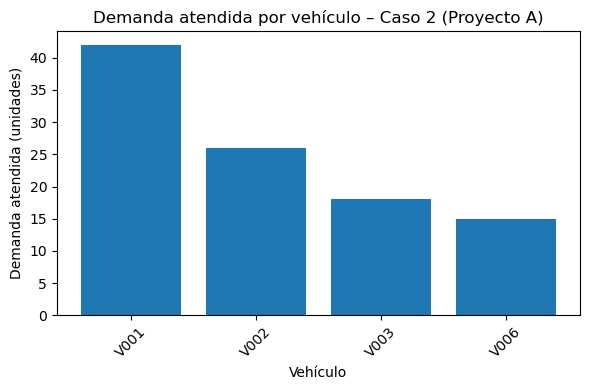

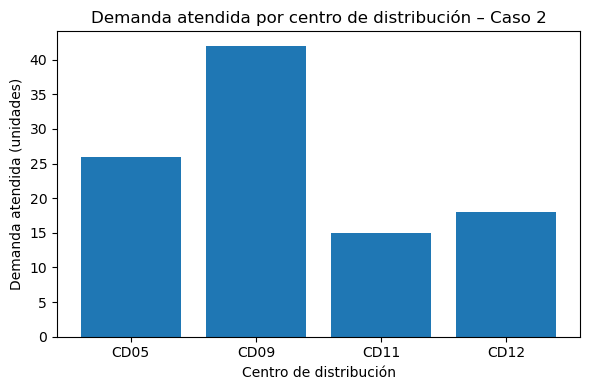

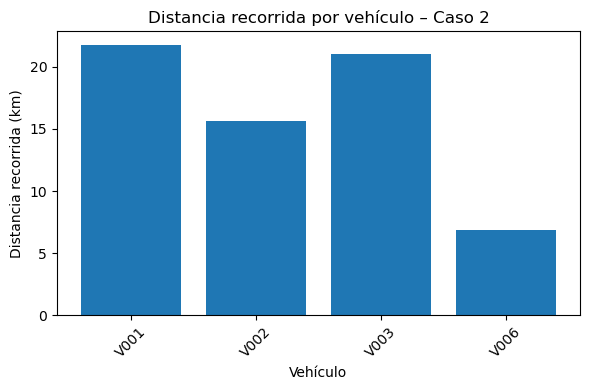

In [3]:
import matplotlib.pyplot as plt

# --- Demanda atendida por vehículo (nivel de carga) ---
plt.figure(figsize=(6, 4))
plt.bar(analysis_df["VehicleId"], analysis_df["TotalDemand"])
plt.xlabel("Vehículo")
plt.ylabel("Demanda atendida (unidades)")
plt.title("Demanda atendida por vehículo – Caso 2 (Proyecto A)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Demanda atendida por centro de distribución (uso de inventario) ---
plt.figure(figsize=(6, 4))
plt.bar(per_depot["DepotId"], per_depot["TotalDemand"])
plt.xlabel("Centro de distribución")
plt.ylabel("Demanda atendida (unidades)")
plt.title("Demanda atendida por centro de distribución – Caso 2")
plt.tight_layout()
plt.show()

# --- Distancia recorrida por vehículo ---
plt.figure(figsize=(6, 4))
plt.bar(analysis_df["VehicleId"], analysis_df["Distance_km"])
plt.xlabel("Vehículo")
plt.ylabel("Distancia recorrida (km)")
plt.title("Distancia recorrida por vehículo – Caso 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis de resultados y conclusiones

Para el Caso 2 del Proyecto A se formuló un modelo de programación lineal entera mixta que representa un problema de ruteo de vehículos con múltiples centros de distribución. La implementación se realizó en Python mediante la librería Pyomo, definiendo variables binarias de ruteo para indicar si un vehículo recorre un arco entre dos nodos, variables de activación de vehículos y variables de asignación de cada vehículo a un centro de distribución. El objetivo del modelo es minimizar el costo total de operación, compuesto por el costo de combustible asociado a la distancia recorrida y los costos de utilización de los vehículos, sujeto a restricciones de capacidad, balance de flujo, servicio a todos los clientes y uso del inventario de los centros de distribución. El modelo se resolvió con un solver de programación lineal entera (MILP) configurado en el entorno de Pyomo, lo que permitió encontrar soluciones exactas para la instancia considerada.

En cuanto al proceso de solución, el modelo se construyó a partir de la información de demanda, coordenadas geográficas de clientes y centros de distribución, distancias y parámetros de capacidad. Una vez instanciado el modelo, se ejecutó el solver y se midió el tiempo de ejecución en el notebook, el cual fue del orden de pocos segundos, lo que indica que la instancia del problema es manejable computacionalmente. El informe del solver arrojó un estado de terminación “óptimo”, lo que significa que la solución que se analiza corresponde a un óptimo global del problema formulado, respetando todas las restricciones de capacidad e inventario.

Los resultados numéricos del Caso 2 muestran que se requieren cuatro vehículos para satisfacer la demanda total de 101 unidades. La solución óptima recorre aproximadamente 65,27 kilómetros en total, con un tiempo operativo agregado cercano a 130,54 minutos (asumiendo una velocidad promedio de 30 km/h) y un costo estimado de combustible alrededor de 106.391 COP. Estos valores resumen el desempeño global del sistema de distribución bajo las condiciones del caso de estudio y sirven como referencia para comparar futuros escenarios o variaciones de parámetros.

Al desagregar los resultados por centro de distribución se observa que CD09 es el que despacha la mayor cantidad de demanda, con 42 unidades, seguido por CD05 con 26 unidades, CD12 con 18 y CD11 con 15 unidades. Esta distribución indica un uso razonablemente balanceado del inventario disponible en la red, donde cada centro atiende principalmente a los clientes de su zona de influencia. Desde la perspectiva de los vehículos, la tabla de resultados y los gráficos muestran que el vehículo V001 concentra la mayor carga y distancia recorrida, mientras que V002, V003 y V006 completan la operación con rutas más cortas y menor volumen de entrega. En conjunto, la asignación de rutas y cargas sugiere un reparto eficiente: no hay vehículos claramente infrautilizados ni centros de distribución saturados.

Las visualizaciones construidas en el notebook permiten interpretar estos resultados de forma clara. El mapa interactivo generado con Folium muestra, sobre la geografía real de Bogotá, las rutas completas de cada vehículo en distintos colores, los centros de distribución como nodos de salida y los clientes atendidos a lo largo de cada ruta. Los pop-ups asociados a los clientes muestran la demanda abastecida en cada ubicación, lo que ayuda a entender visualmente los niveles de carga. Complementariamente, los gráficos de barras construidos con Matplotlib para la demanda atendida por vehículo, la demanda por centro de distribución y la distancia recorrida por vehículo refuerzan el análisis cuantitativo y facilitan identificar desequilibrios o patrones relevantes en la operación.

Desde el punto de vista cualitativo, la solución obtenida presenta rutas compactas y coherentes con la distribución espacial de la demanda: los vehículos cubren grupos de clientes cercanos y parten del centro de distribución más conveniente. La distancia total recorrida es relativamente baja para una operación urbana, y el uso combinado de cuatro vehículos permite cubrir toda la demanda sin violar capacidades ni inventarios. El hecho de que la velocidad promedio calculada sea consistente entre vehículos indica que la modelación del tiempo de viaje y su relación con la distancia es adecuada. En términos prácticos, la empresa podría implementar un plan de distribución similar al sugerido por el modelo para reducir costos de combustible y asegurar niveles adecuados de servicio.

En cuanto al análisis de sensibilidad, aunque en esta entrega no se resolvieron explícitamente escenarios alternativos, del comportamiento del modelo se pueden anticipar algunas tendencias. Un aumento en la demanda de los clientes, manteniendo fija la flota y las capacidades, tendería a incrementar la distancia total y posiblemente requeriría activar vehículos adicionales o incrementar la capacidad de los existentes. Una reducción en la capacidad de los vehículos llevaría a rutas más fragmentadas, mayor número de viajes o incluso a la necesidad de agregar vehículos para mantener el mismo nivel de servicio. Cambios en la disponibilidad de inventario en los centros de distribución o en sus ubicaciones modificarían la asignación de vehículos y clientes, lo que podría aumentar o reducir la distancia y el costo total dependiendo de cómo se desplace la demanda. Finalmente, variaciones en el costo del combustible tendrían un impacto casi lineal sobre el costo total, pero no necesariamente cambiarían la estructura de las rutas si las distancias relativas se mantienen.

En síntesis, el modelo implementado permite capturar adecuadamente la complejidad del problema de distribución con múltiples centros y restricciones de capacidad, y proporciona una solución óptima que equilibra el uso de vehículos, el inventario de los centros y la distancia recorrida. Las visualizaciones geográficas y los gráficos de resumen facilitan la comprensión de los resultados y demuestran que la propuesta es coherente y aplicable en un contexto realista. Este caso confirma que la combinación de formulación MILP, solución exacta con Pyomo y herramientas de visualización como Folium y Matplotlib constituye una metodología sólida para apoyar la toma de decisiones en problemas logísticos de este tipo.
